In [356]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
import multiprocessing  
from multiprocessing import Pool, cpu_count
import scipy.constants as sc
import time
import datetime
import os
from matplotlib import cm
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
plt.rcParams['figure.dpi'] = 100

saveResults = True

N = 3

# Operators
a = tensor(destroy(N), qeye(N), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(N))
r = tensor(qeye(N), qeye(N), destroy(N))

Na = a.dag() * a
Nb = b.dag() * b
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xr = r.dag() + r
Pa = 1j * (a.dag() - a)
Pb = 1j * (b.dag() - b)
Pr = 1j * (r.dag() - r)

###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
###############################

In [357]:
from Solver import Solver_TwoModesCoupledToMR_steadystate

# Frequencies: wa, wb, wr
w = 2 * pi * array([4.0, 4.1, 1.0]) * 1e9
wr = w[2]

# Coupling strength: ga, gb (= ga)  
#ga = 2* pi * array([10,15,20]) * 1e6
#gb = 2* pi * array([10,15,20]) * 1e6

#g = [ga,gb]

g = 2* pi * array([20,20]) * 1e6

etaA = (g[0]*g[0])/wr
etaB = (g[1]*g[1])/wr
etaAB = 2 * (g[0]*g[1])/wr 

J =  2* pi * 0 * 1e3

# Drive frequnecies: Omega_a
Omega_a_initial = w[0] - 3 * (etaA +  2 * etaAB)
Omega_a_final = w[0] + 1 * (etaA +  2 * etaAB)

Omega_a_list = linspace(Omega_a_initial, Omega_a_final, 1000)

Omega = w[1] - 2 * pi * 1200 * 1e3

# Drive amplitude: Ea, Eb
E_drive = 2 * pi * array([80, 80]) * 1e3


# Dissipation rates: kappa_a, kappa_b, gamma
kappa = 2 * pi * array([50, 50, 300]) * 1e3 

# Temperatures: Ta, Tb, Tr
T = array([0, 0, 0.01])


if __name__ == '__main__':
    pool = Pool(60)
    procs = Omega_a_list
    aresults = [pool.apply_async(Solver_TwoModesCoupledToMR_steadystate, args=(N,
                                                                            w,
                                                                            g,
                                                                            J,
                                                                            E_drive,
                                                                            Omega,
                                                                            kappa,
                                                                            T,
                                                                            proc)) for proc in procs]
    
    pool.close()
    pool.join()
        
    results = [ar.get() for ar in aresults]




In [358]:
etaA/(2*pi*1e3), etaB/(2*pi*1e3), etaAB/(2*pi*1e3)

(400.00000000000006, 400.00000000000006, 800.0000000000001)

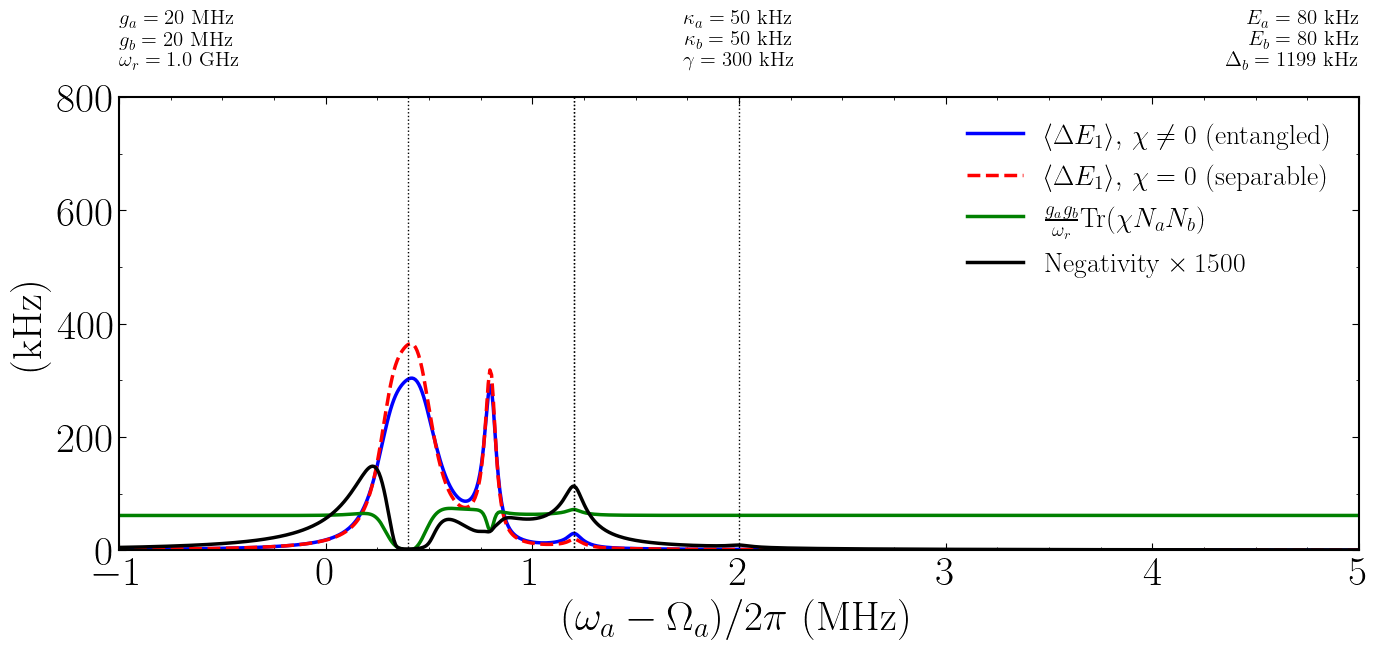

In [359]:
x_list = (w[0] - Omega_a_list) / (2*pi*1e6)
y_list_1 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i) + etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_2 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i))/(2*pi*1e3) for i in results]
y_list_3 = [(etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_4 = [1500*negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=False) for i in results]
#y_list_5 = [100*(1 - ((expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2))) for i in results]
#y_list_6 = [800*(1 - ((ptrace(i,(0)))**2).tr()) for i in results]

y_list_3 = y_list_3 + abs(min(y_list_3))

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi \neq 0$ (entangled)')
axes.plot(x_list, y_list_2, color = 'r', linestyle='--', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi = 0$ (separable)')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = r'$\frac{g_a g_b}{\omega_r}$Tr$(\chi N_a N_b)$')
axes.plot(x_list, y_list_4, color = 'black', linestyle='-', lw = lw, label = r'Negativity $\times\,1500$')
#axes.plot(x_list, y_list_5, color = 'yellow', linestyle='-', lw = lw, label = r'$100\times(1-g^2(0))$')
#axes.plot(x_list, y_list_6, color = 'orange', linestyle='-', lw = lw, label = r'Linear entropy $\times\,1000$')

axes.vlines(etaA/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
axes.vlines((etaA + 2*etaAB)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
axes.vlines((3*etaA)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'(kHz)', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=1, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,800)


start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

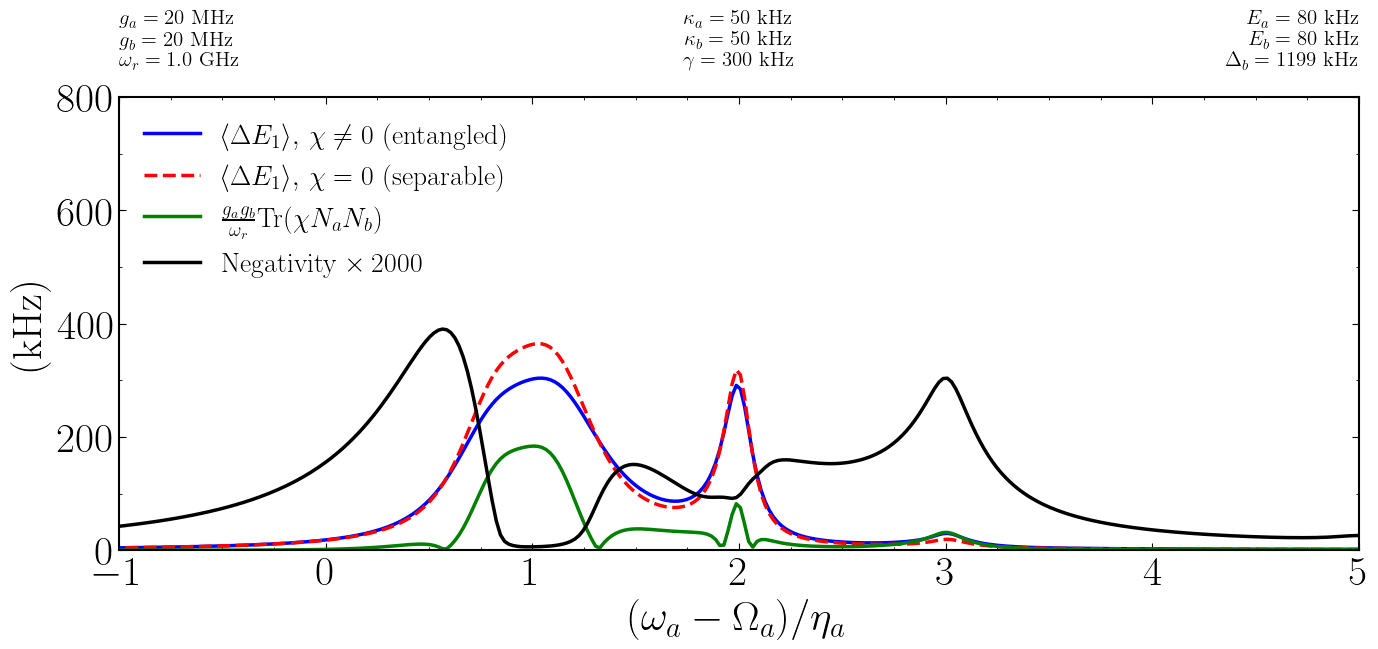

In [360]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i) + etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_2 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i))/(2*pi*1e3) for i in results]
y_list_3 = [3*abs(etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_4 = [1500*negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=True) for i in results]
#y_list_5 = [100*(1 - ((expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2))) for i in results]
#y_list_6 = [800*(1 - ((ptrace(i,(0)))**2).tr()) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi \neq 0$ (entangled)')
axes.plot(x_list, y_list_2, color = 'r', linestyle='--', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi = 0$ (separable)')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = r'$\frac{g_a g_b}{\omega_r}$Tr$(\chi N_a N_b)$')
axes.plot(x_list, y_list_4, color = 'black', linestyle='-', lw = lw, label = r'Negativity $\times\,2000$')
#axes.plot(x_list, y_list_5, color = 'yellow', linestyle='-', lw = lw, label = r'$100\times(1-g^2(0))$')
#axes.plot(x_list, y_list_6, color = 'orange', linestyle='-', lw = lw, label = r'Linear entropy $\times\,1000$')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a $', rotation=0, fontsize=fs)
axes.set_ylabel(r'(kHz)', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,800)


start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

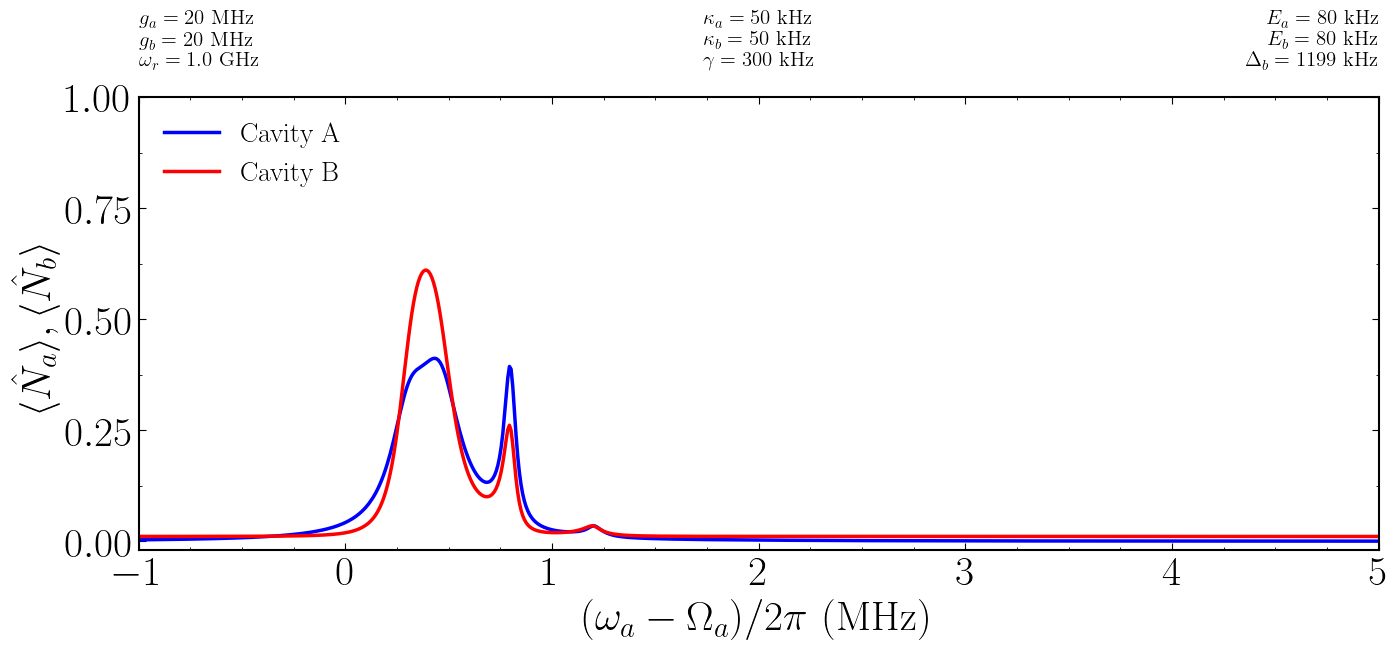

In [361]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Na, i) for i in results]
y_list_2 = [expect(Nb, i) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')

#axes.vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,1)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

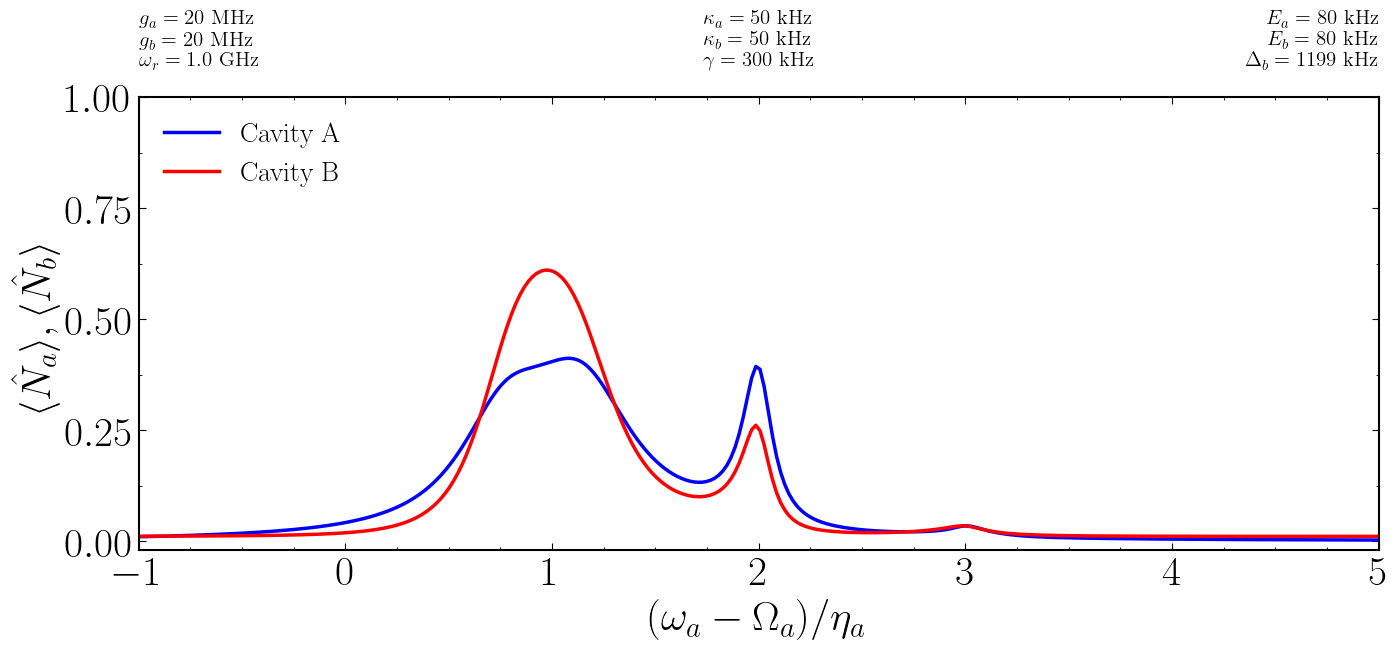

In [362]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [expect(Na, i) for i in results]
y_list_2 = [expect(Nb, i) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a$', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,1)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

In [363]:
rhoAB = ptrace(results[698],(0,1))
rhoAB

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.94719365e-01+0.00000000e+00j  3.36625763e-03+2.17629105e-02j
  -5.22555641e-03-4.86817182e-03j  1.22933030e-01-8.74081611e-03j
   2.75719260e-02+1.53606853e-02j  3.61196250e-03-2.54174840e-03j
   3.40978388e-03-1.73016218e-02j  7.05540471e-04-2.11899811e-03j
  -1.53684532e-04-1.78614748e-04j]
 [ 3.36625763e-03-2.17629105e-02j  1.72402583e-01+0.00000000e+00j
   5.69541773e-02-2.28841305e-02j -3.79344073e-03-3.00008145e-03j
   9.47658180e-04-3.20667932e-03j  2.69244882e-04-2.93616842e-03j
  -3.73001334e-04+4.03710699e-05j  1.64563691e-04-6.42181918e-05j
  -8.53960759e-05-4.10308008e-05j]
 [-5.22555641e-03+4.86817182e-03j  5.69541773e-02+2.28841305e-02j
   1.30800557e-01+0.00000000e+00j -9.50401574e-04+1.42330871e-03j
   1.36483643e-03-5.58461807e-03j -9.98696769e-05-6.54022402e-03j
   1.27721304e-04+1.90306660e-04j -2.53517274e-04-4.62395651e-05j
  -1.84945921e-04+5.46503727e-06j]
 [ 1.22

In [364]:
rhoATB = partial_transpose(rhoAB,(0,1))

In [365]:
rhoAB.eigenenergies()

array([1.99299638e-08, 3.04575748e-06, 1.09040481e-05, 4.71509031e-04,
       7.48998176e-02, 8.53333910e-02, 1.96604697e-01, 2.17378930e-01,
       4.25297685e-01])

In [366]:
rhoATB.eigenenergies()

array([-1.40438310e-03,  4.36329511e-07,  1.47736791e-04,  6.21932366e-04,
        6.06306166e-02,  8.67697222e-02,  2.07836495e-01,  2.30490415e-01,
        4.14907029e-01])

In [367]:
rho = results[698] 
(rho - tensor(ptrace(rho, (0)), ptrace(rho, (1)), ptrace(rho, (2))))

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[-2.27819033e-02+0.00000000e+00j -6.31302483e-03+1.14561295e-06j
  -1.42708375e-04+4.66594947e-08j -5.85153636e-02+4.10301224e-03j
  -1.17267850e-03+8.12325068e-05j -2.70743817e-05-1.81050504e-06j
  -4.80194220e-03+6.06754053e-03j -1.99644491e-04+2.52270169e-05j
  -5.68443256e-06-5.21417866e-07j  5.67124744e-02+1.06358115e-03j
   1.13173380e-03+2.09720710e-05j  4.93888069e-06+1.94621155e-06j
   1.40068151e-02+1.35282880e-02j  8.26760674e-04+5.74842382e-04j
   2.48813351e-05+1.64308791e-05j  3.99724636e-03-2.78320409e-04j
   2.23219281e-04-1.06453494e-04j  9.28877432e-06-5.39945945e-06j
   1.59417010e-03-8.01421131e-03j  9.93150730e-05-5.03439406e-04j
   3.00629975e-06-1.52711637e-05j -1.58616959e-04-4.04950987e-04j
   2.47642898e-05-9.21726102e-05j  1.38773069e-06-4.57750931e-06j
   1.66070675e-04-1.26372025e-04j -5.82593569e-06-1.31564814e-05j
  -5.44786855e-07-7.76534250e-07j]
 [-

In [368]:
chiAB = (rho - tensor(ptrace(rho, (0)), ptrace(rho, (1)), ptrace(rho, (2))))

In [369]:
sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1])

array([2.57698672e-07, 5.89171995e-07, 1.23243658e-06, 1.39914008e-06,
       2.15506194e-06, 3.46747448e-06, 3.91715003e-06, 4.12136126e-06,
       7.06265844e-06, 8.96933987e-06, 2.16653341e-05, 9.76561046e-05,
       1.30035023e-04, 2.30244030e-04, 2.37119582e-04, 3.88633131e-04,
       5.13534169e-04, 7.24539706e-04, 8.35783263e-04, 4.71363452e-03,
       5.99864284e-03, 2.36075565e-02, 5.50223579e-02, 5.86165321e-02,
       1.06539800e-01])

In [370]:
sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[2:-1]))

0.25771064791763704

In [371]:
sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1]))

0.2577109056163087

In [372]:
def find_local_maxima(data):
    """Find all local maxima in a list of values."""
    local_maxima = []
    
    # Check if the list has less than 3 elements
    if len(data) < 3:
        # In case of lists with less than 3 elements, there can't be a local maximum in the middle
        if len(data) == 1:
            return [(0, data[0])]
        if len(data) == 2:
            if data[0] > data[1]:
                return [(0, data[0])]
            if data[1] > data[0]:
                return [(1, data[1])]
        return []
    
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            local_maxima.append((i, data[i]))
    
    # Handle the boundary cases if the first or last element is a local maximum
    if data[0] > data[1]:
        local_maxima.insert(0, (0, data[0]))
    if data[-1] > data[-2]:
        local_maxima.append((len(data) - 1, data[-1]))
    
    return local_maxima

In [373]:
find_local_maxima(y_list_1)

[(599, 0.034733247206464424),
 (650, 0.3936365503661138),
 (695, 0.4120097836251916)]

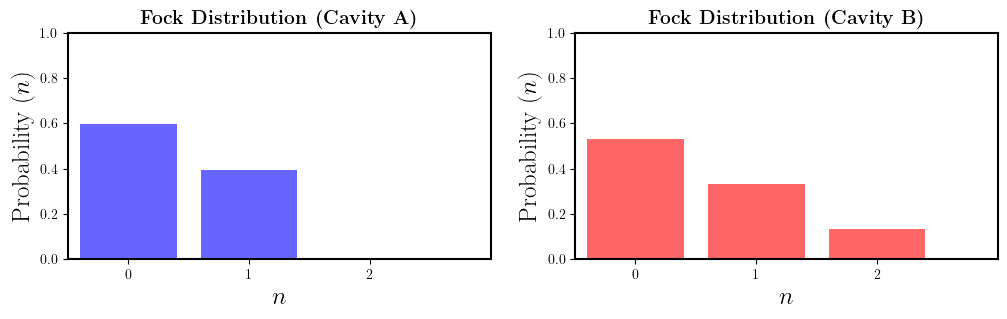

In [374]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

p = 698

axes[0].bar(arange(0, N), real(ptrace(results[p],(0)).diag()), label='Cavity A' ,color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)

axes[1].bar(arange(0, N), real(ptrace(results[p],(1)).diag()), color="red", alpha=0.6)
axes[1].set_title(r"\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

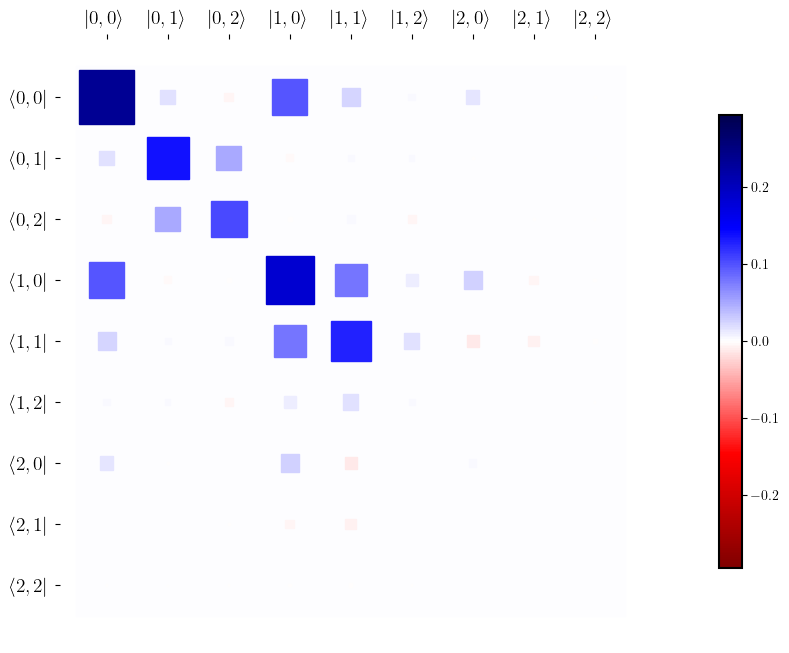

In [375]:
#hinton(ptrace(results[p],(0,1))) # xlabels=xlabels, ylabels=xlabels)

fig, axes = plt.subplots(1, 1, figsize=(10,8))

hinton(ptrace(results[p],(0,1)),ax=axes,  cmap=cm.seismic_r)

plt.show()

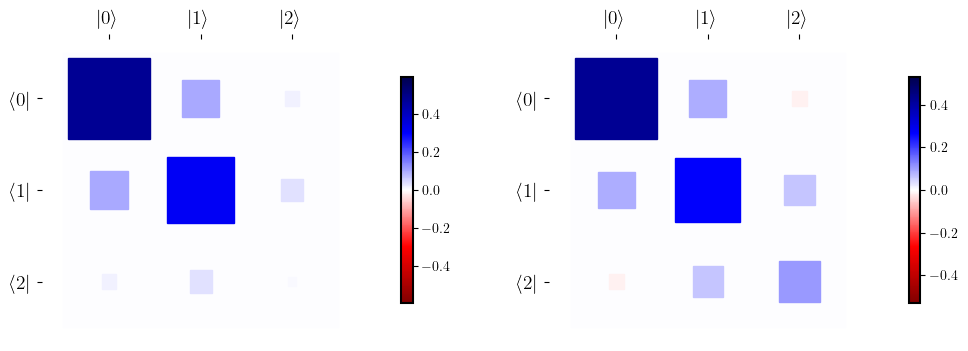

In [376]:
#hinton(ptrace(results[p],(0,1))) # xlabels=xlabels, ylabels=xlabels)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

hinton(ptrace(results[p],(0)),ax=axes[0],  cmap=cm.seismic_r)
hinton(ptrace(results[p],(1)),ax=axes[1],  cmap=cm.seismic_r)

plt.show()

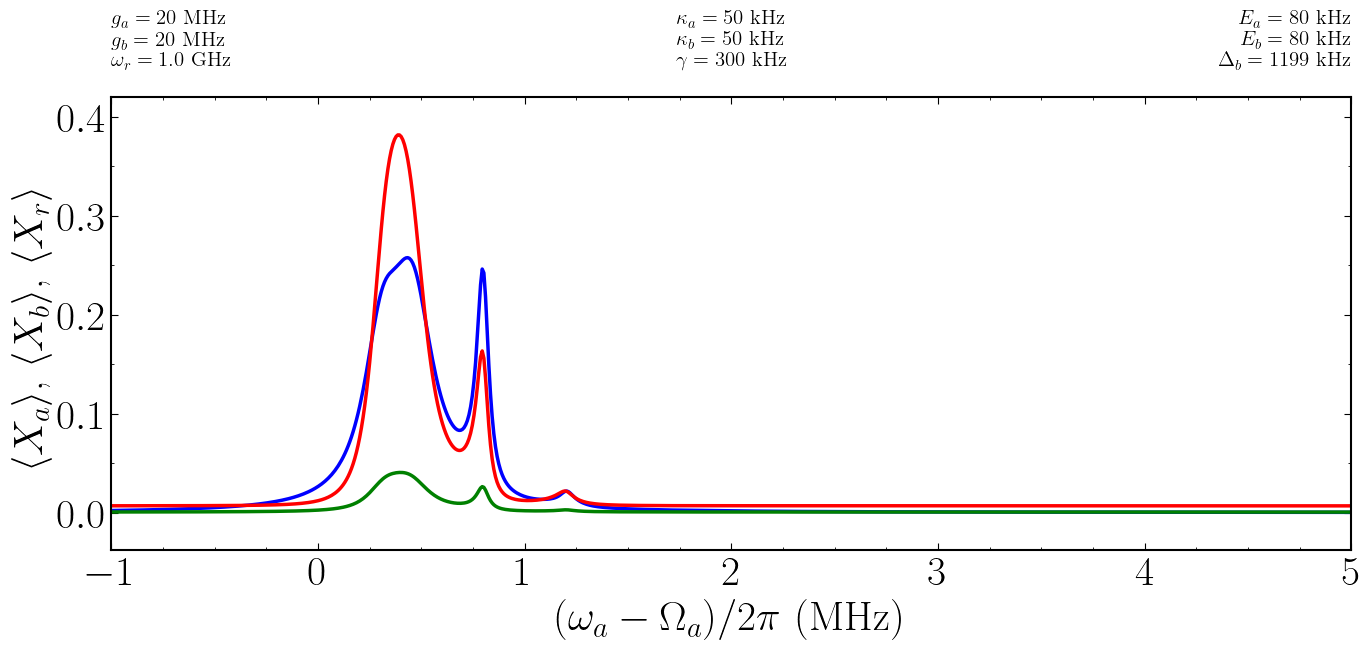

In [377]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Xa, i)  for i in results]
y_list_2 = [expect(Xb, i)  for i in results]
y_list_3 = [expect(Xr, i)  for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = 'Mechanical Resonator')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle X_a\rangle$, $\langle X_b\rangle$, $\langle X_r\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
#axes.set_ylim(-0.01,0.11)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

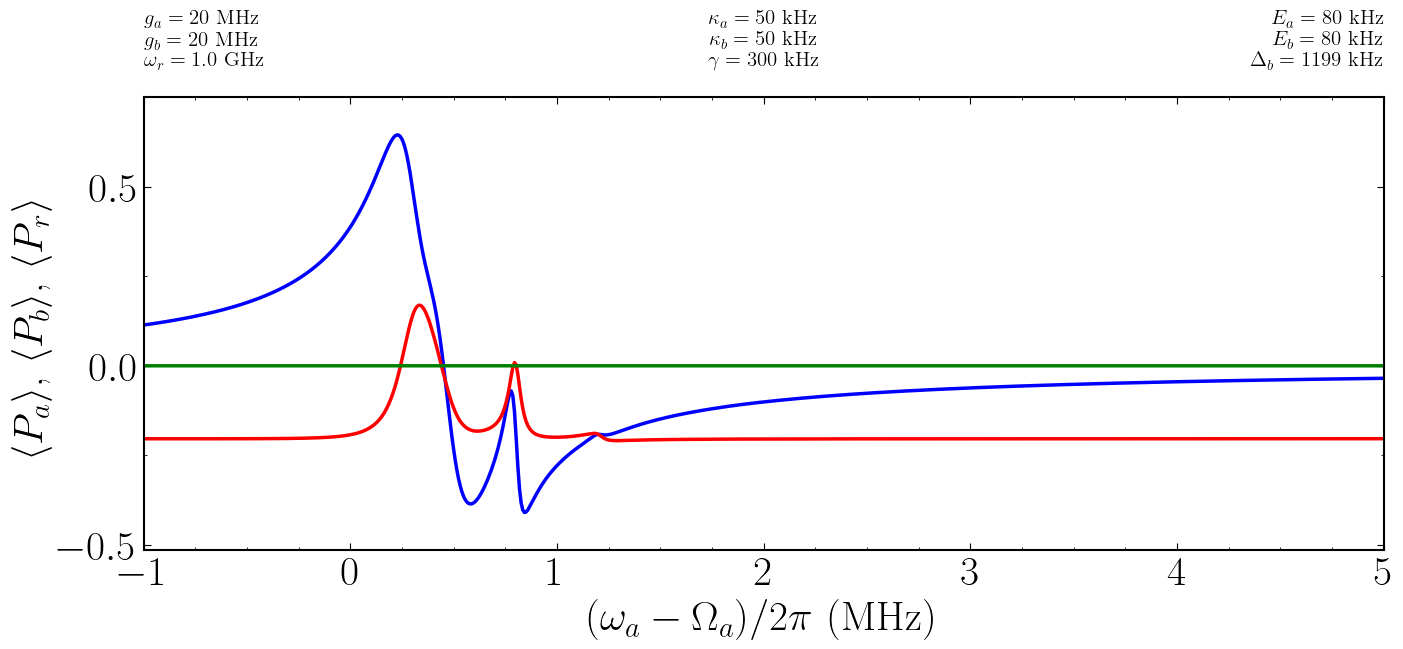

In [378]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Pa, i)  for i in results]
y_list_2 = [expect(Pb, i)  for i in results]
y_list_3 = [expect(Pr, i)  for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = 'Mechanical Resonator')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle P_a\rangle$, $\langle P_b\rangle$, $\langle P_r\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
#axes.set_ylim(-0.01,0.11)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

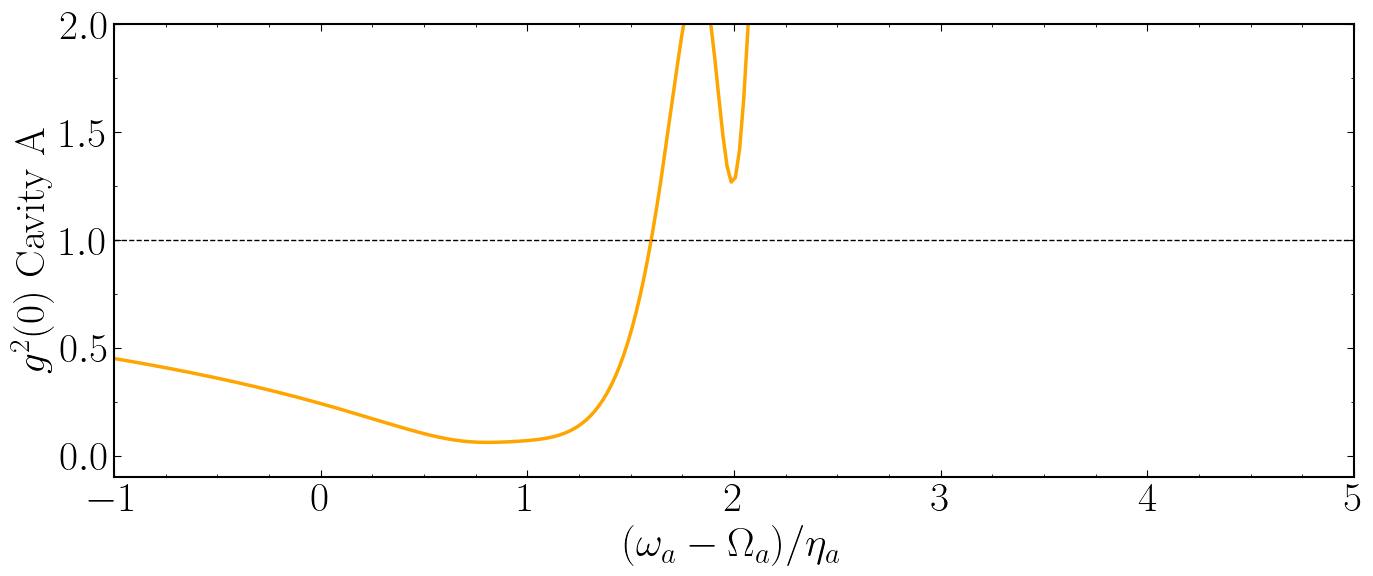

In [379]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [(expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2)  for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'orange', linestyle='-', lw = lw)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a$', rotation=0, fontsize=fs)
axes.set_ylabel(r'$g^2(0)$ Cavity A', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
axes.set_ylim(-0.1,2)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))
axes.hlines(1, start, end, color = 'black', linestyle='--', lw = 1)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.margins(x=0.1, y=0.1)